# 第 6 章: 機械学習


### 50. データの入手・整形


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

seed = 0
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)

In [2]:

news_df = pd.read_csv("./data/news/newsCorpora.csv", sep="\t", header=None)
news_df.columns = ["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"]

# news_df.head()
publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
extracted_news_df = news_df[news_df["publisher"].isin(publishers)]

# データをランダムにシャッフル
df_shuffled = extracted_news_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# データの件数を計算
n = len(df_shuffled)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# データを分割
train = df_shuffled[:train_end]
val = df_shuffled[train_end:val_end]
test = df_shuffled[val_end:]

import os
os.makedirs("data/ch6", exist_ok=True)
pd.DataFrame(train)[["category", "title"]].to_csv("./data/ch6/train.txt", sep="\t", index=False, header=None)
pd.DataFrame(test)[["category", "title"]].to_csv("./data/ch6/test.txt", sep="\t", index=False, header=None)
pd.DataFrame(val)[["category", "title"]].to_csv("./data/ch6/val.txt", sep="\t", index=False, header=None)

### 51. 特徴量抽出

In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

def get_embeddings(
        sentences: list[str], 
        model: str = "sentence-transformers-testing/stsb-bert-tiny-safetensors"
):
    model = SentenceTransformer(model)
    embs = model.encode(sentences)
    return embs

train_titles, train_categories = train["title"].values, train["category"].values
print(f"{len(train_titles)=}")

train_embs = get_embeddings(train_titles)
print(f"{train_embs.shape=}")

/Users/obi/Code/github.com/obizip/python-nlp100/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


len(train_titles)=10672
train_embs.shape=(10672, 128)


### 52. 学習

In [4]:
X_train = train_embs
y_train = train_categories
print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
clf = LogisticRegression(random_state=seed, max_iter=1000).fit(X_train, y_train)
y_pred_train = clf.predict(X_train)

X_train.shape=(10672, 128)
y_train.shape=(10672,)


### 53. 予測

In [5]:
test_titles, test_categories = test["title"].values, test["category"].values
print(f"{len(test_titles)=}")

X_test = get_embeddings(test_titles)
print(f"{X_test.shape=}")
y_test = test_categories
print(f"{y_test.shape=}")

y_pred = clf.predict(X_test)

len(test_titles)=1334
X_test.shape=(1334, 128)
y_test.shape=(1334,)


### 54. 正解率の計測

In [6]:
print(f"{accuracy_score(y_train, y_pred_train)=}")
print(f"{accuracy_score(y_test, y_pred)=}")

accuracy_score(y_train, y_pred_train)=0.8654422788605697
accuracy_score(y_test, y_pred)=0.8620689655172413


### 55. 混同行列の作成

In [7]:
print(f"{confusion_matrix(y_train, y_pred_train)}")
print(f"{confusion_matrix(y_test, y_pred)}")

[[4074  193   51  175]
 [ 155 3966   43   68]
 [ 111   74  498   34]
 [ 379  129   24  698]]
[[510  15   6  33]
 [ 21 480   7   9]
 [ 16  11  64   5]
 [ 46  13   2  96]]


### 56. 適合率，再現率，F1スコアの計測

In [8]:
print("[train data]")
print(classification_report(y_train, y_pred_train))
print("-"*80)
print("[test data]")
print(classification_report(y_test, y_pred))

[train data]
              precision    recall  f1-score   support

           b       0.86      0.91      0.88      4493
           e       0.91      0.94      0.92      4232
           m       0.81      0.69      0.75       717
           t       0.72      0.57      0.63      1230

    accuracy                           0.87     10672
   macro avg       0.82      0.78      0.80     10672
weighted avg       0.86      0.87      0.86     10672

--------------------------------------------------------------------------------
[test data]
              precision    recall  f1-score   support

           b       0.86      0.90      0.88       564
           e       0.92      0.93      0.93       517
           m       0.81      0.67      0.73        96
           t       0.67      0.61      0.64       157

    accuracy                           0.86      1334
   macro avg       0.82      0.78      0.79      1334
weighted avg       0.86      0.86      0.86      1334



### 57. 特徴量の重みの確認

In [9]:
clf.coef_.shape
clf.classes_
for i in range(len(clf.classes_)):
    class_name = clf.classes_[i]
    ws = clf.coef_[i]
    indices = np.argsort(ws)
    top = [f"{i}: {ws[i]:.3}" for i in indices[-10:]]
    worst = [f"{i}: {ws[i]:.3}" for i in indices[:10]]
    print(class_name)
    print(f"  [top]   {', '.join(top)}")
    print(f"  [worst] {', '.join(worst)}")

b
  [top]   95: 0.411, 121: 0.416, 33: 0.525, 106: 0.589, 111: 0.596, 85: 0.652, 75: 0.761, 7: 0.79, 53: 0.792, 47: 0.986
  [worst] 83: -1.46, 62: -0.828, 55: -0.828, 79: -0.665, 109: -0.593, 91: -0.584, 10: -0.525, 87: -0.521, 72: -0.474, 64: -0.473
e
  [top]   46: 0.373, 91: 0.455, 21: 0.468, 68: 0.496, 65: 0.503, 55: 0.564, 6: 0.611, 80: 0.612, 62: 0.676, 102: 0.725
  [worst] 60: -0.803, 111: -0.797, 9: -0.628, 76: -0.589, 121: -0.542, 24: -0.531, 92: -0.472, 101: -0.427, 66: -0.417, 86: -0.417
m
  [top]   35: 0.458, 110: 0.477, 19: 0.478, 101: 0.486, 62: 0.488, 54: 0.552, 29: 0.556, 83: 0.594, 81: 0.639, 94: 0.765
  [worst] 118: -0.686, 12: -0.593, 77: -0.565, 7: -0.499, 47: -0.409, 106: -0.401, 108: -0.387, 52: -0.376, 42: -0.351, 65: -0.347
t
  [top]   26: 0.41, 123: 0.435, 1: 0.46, 48: 0.466, 0: 0.506, 118: 0.509, 60: 0.511, 109: 0.681, 2: 0.696, 83: 0.737
  [worst] 53: -0.631, 85: -0.516, 3: -0.507, 110: -0.477, 7: -0.474, 33: -0.461, 31: -0.438, 81: -0.431, 17: -0.43, 75: -0.4

### 58. 正則化パラメータの変更

In [10]:
val_titles, val_categories = val["title"].values, val["category"].values
X_val = get_embeddings(val_titles)
print(f"{X_val.shape=}")
y_val = val_categories
print(f"{y_val.shape=}")

X_val.shape=(1334, 128)
y_val.shape=(1334,)


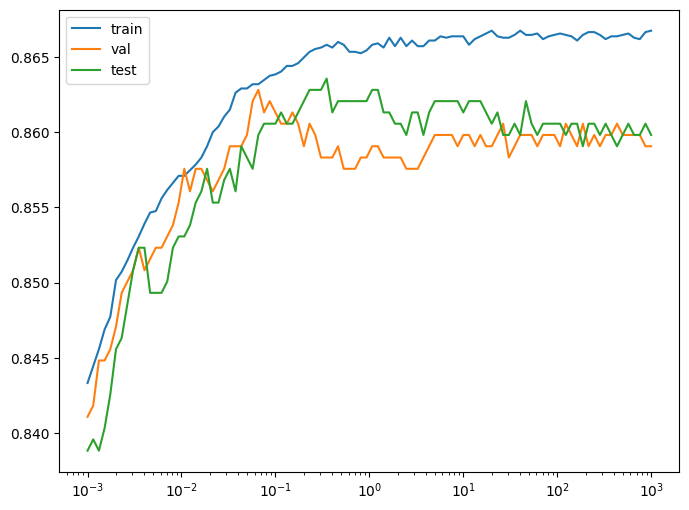

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict

cs = np.logspace(-3, 3, 100)
accs = defaultdict(list)

plt.figure(figsize=(8, 6))
for title, X, y in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
    for c in cs:
        clf = LogisticRegression(random_state=seed, max_iter=1000, C=c)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X)
        acc = accuracy_score(y, y_pred)
        accs[title].append(acc)
    plt.plot(cs, accs[title], label=title)
plt.xscale("log")
plt.legend()
plt.show()

### 59. ハイパーパラメータの探索

In [19]:
best_params = {}
max_acc = -np.inf
for C in [1, 10, 100]:
    for solver in ['saga', 'liblinear', 'lbfgs']:
        clf = LogisticRegression(random_state=seed, max_iter=1000, C=C, solver=solver)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        print(f"{C=}\t{solver=}\t\t{acc=}")
        if acc > max_acc:
            best_params.update(C=C, solver=solver)

clf = LogisticRegression(random_state=seed, max_iter=1000, **best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"{best_params=}")
print(f"best_{acc=}")
print(classification_report(y_test, y_pred))

C=1	solver='saga'		acc=0.8590704647676162
C=1	solver='liblinear'		acc=0.861319340329835
C=1	solver='lbfgs'		acc=0.8583208395802099
C=10	solver='saga'		acc=0.8598200899550225
C=10	solver='liblinear'		acc=0.8620689655172413
C=10	solver='lbfgs'		acc=0.8598200899550225
C=100	solver='saga'		acc=0.8605697151424287
C=100	solver='liblinear'		acc=0.8628185907046477
C=100	solver='lbfgs'		acc=0.8590704647676162
best_params={'C': 100, 'solver': 'lbfgs'}
acc=0.8598200899550225
              precision    recall  f1-score   support

           b       0.86      0.90      0.88       564
           e       0.92      0.93      0.93       517
           m       0.81      0.67      0.73        96
           t       0.66      0.61      0.63       157

    accuracy                           0.86      1334
   macro avg       0.81      0.78      0.79      1334
weighted avg       0.86      0.86      0.86      1334

